In [1]:
# Plotting script for results

import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
def get_values(component_results, parameter):
    # Get values, set nan to zero
    results = component_results[parameter].values
    results[np.isnan(results)] = 0
    return results

def read_component_results(results_dir, pickle_file):
    # Read in the data from pickle file
    with open(os.path.join(results_dir, pickle_file), 'rb') as f:
        results = pickle.load(f)
        # Get results dictionaries
        component_results = results['component results']
        # Drop Load and phs_power from component results
        component_results = component_results.drop(['Load', 'Link'], level=0)
        # Drop carriers containing 'co2' from component results
        component_results = component_results.drop([x for x in component_results.index.get_level_values(1) if 'co2' in x], level=1)
        # Add values of same carrier
        component_results = component_results.groupby(level=1).sum()
    return component_results

def get_result(component_results, parameter):
    # Get values, set nan to zero
    if parameter == 'cost':
        opex = get_values(component_results, 'Operational Expenditure')
        capex = get_values(component_results, 'Capital Expenditure')
        results = 8760 * opex + capex
    else:
        results = get_values(component_results, 'Optimal Capacity')
    result_dict = dict(zip(component_results.index, results))
    return result_dict

def get_colors(component_results):
    # 13 different colors mapped to all components, no duplicates
    colors = ['blue', 'green', 'red', 'purple', 'lime', 'pink', 'gray', 'teal', 'orange', 'brown', 'cyan', 
              'magenta',  'yellow', 'lavender', 'beige', 'maroon', 'mint', 'olive', 'apricot', 'navy']

    color_dict = dict(zip(component_results, colors))
    return color_dict

In [3]:
# Plotting results for cost and capacity
def plot_results(results_dir, color_dicts, poi):
    max_result = 0
    fig, ax = plt.subplots(figsize=(10, 5))
    # Loop over all case pickle files in all_firm_case folder
    # Sort such that starting with all_firm_all
    for case_file in sorted(os.listdir(results_dir)):
        # Skip if not pickle file
        if not case_file.endswith('.pickle'):
            continue

        # Load results
        component_results = read_component_results(results_dir, case_file)
        # Calculate results
        results = get_result(component_results, poi)
        
        # Sort results by value in descending order
        results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

        # Stacked bar plot of results
        bottom_value = 0
        for component in results:
            ax.bar(case_file.replace('all_firm_', '').replace('.pickle', ''), results[component], width=0.25,
                    color=color_dict[component], bottom=bottom_value, label=component)
            bottom_value += results[component]

        # Get max result
        if sum(results.values()) > max_result:
            max_result = sum(results.values())
        
        if case_file == 'all_firm_all.pickle':
            handles, labels = ax.get_legend_handles_labels()
            labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

    # Plot legend, label with second part of index of component_results
    ax.legend(handles, labels, loc='upper left', fontsize='small')

    # Plot labels
    ax.set_xlabel('Case')
    ax.set_ylabel('Total {0} [{1}]'.format(poi, '€' if poi == 'cost' else 'MW'))
    ax.set_title('Total {0} of all cases'.format(poi))
    # Avoid x label overlap
    ax.tick_params(axis='x', labelrotation=5)

    n_cases = len([case for case in os.listdir(results_dir) if case.endswith('.pickle')])
    # Axis limits
    ax.set_xlim(-1, n_cases-0.5)
    ax.set_ylim(0, 1.2*max_result)

    # Save plot
    fig.savefig('output_data/total_{0}.png'.format(poi))

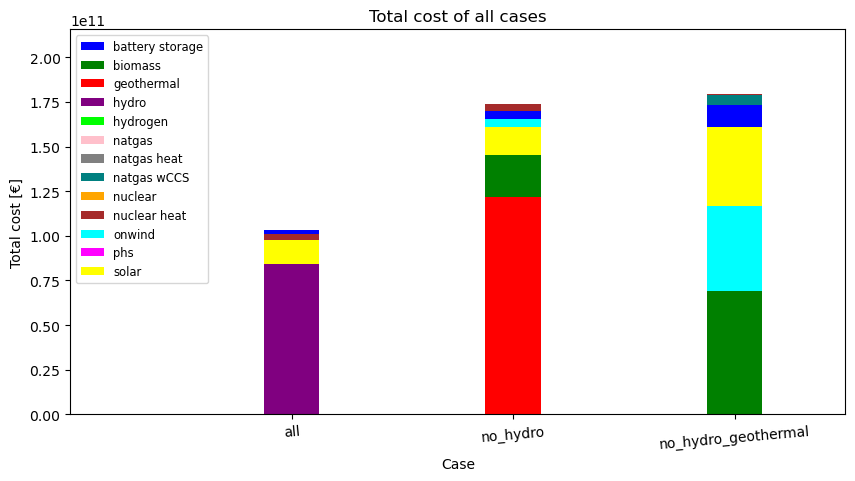

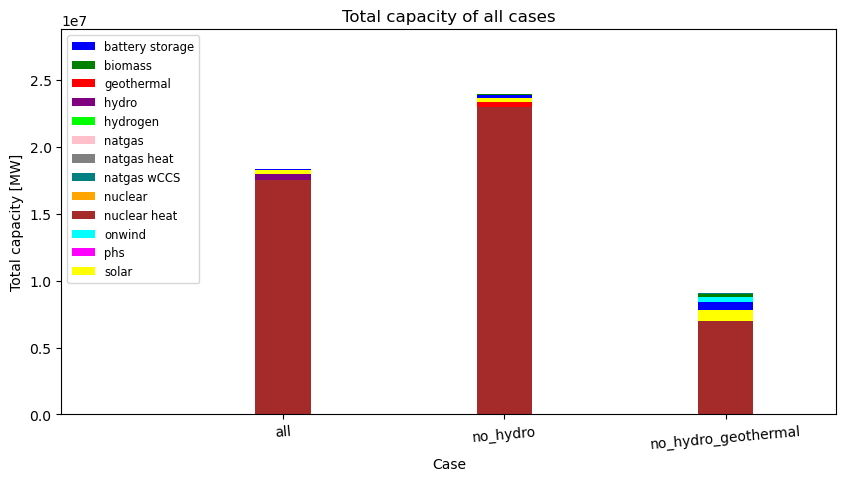

In [4]:
# Results directory
results_dir = 'output_data/all_firm_case'

# Get color map
all_comp = read_component_results(results_dir, 'all_firm_all.pickle').index
color_dict = get_colors(all_comp)

# Plot
plot_results(results_dir, color_dict, 'cost')
plot_results(results_dir, color_dict, 'capacity')